# Variational Auto Encoder Pytorch Implementation for MNSIT 

First we import the required packages.

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from sklearn.manifold import  TSNE
from sklearn.decomposition import PCA


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Expermimental Set Up
The model we chosse is quite simple. We are using only linear layers with the ReLU activation function. 

In [3]:
config = {
    'model_name': 'VAE',
    'dataset': 'FMNIST',
    'seed': 1,
    # Model setup 
    'input_dim': 784,
    'batch_size': 128,
    'num_epochs': 15,
    'learning_rate': 0.0002,
    'latent_dim': 8
}

# DEVICE for Mac for Windows use CUDA
DEVICE = torch.device("mps")
print(DEVICE)

# Set the seed
torch.manual_seed(config['seed'])

mps


# Load Dataset 
We agreed using the MNSIT dataset first. The code is loaded from the helper folder

In [8]:
import torchvision.transforms as transforms

def data(dataset, batch_size):
    # Define common transformations for both MNIST and FMNIST
    transform = [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: x.view(-1))
    ]
    
    # Dataset selection and loader creation
    if dataset == 'MNIST':
        from utils.dataloaders.full_dataloaders import DataLoaderMNIST  # Example import, adjust as needed
        data_loader = DataLoaderMNIST(batch_size=batch_size, transformation=transform)
    elif dataset == 'FMNIST':
        from utils.dataloaders.full_dataloaders import DataLoaderFashionMNIST # Example import, adjust as needed
        data_loader = DataLoaderFashionMNIST(batch_size=batch_size, transformation=transform)
    else:
        raise ValueError(f"Invalid dataset: {dataset}. Supported datasets are 'MNIST' and 'FMNIST'.")
    
    return data_loader


dataloader = data(config['dataset'], config['batch_size'])

train_loader = dataloader.train_loader


# Model VAE  


In [9]:
# Model comes from python file for later usage 
# Model is defined in model_def.py
from models.definitions.vae import VAE
model = VAE(in_dim=784, latent_dim= config['latent_dim']).to(DEVICE)

In [10]:
# Printn number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


1152192


# Training Loop


In [11]:
# Assuming imports and model class definitions are already done
optimizer = Adam(model.parameters(), lr=config['learning_rate'])
# Training function
def train(model, data_loader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        recon_loss_total = 0.0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(DEVICE)  # Move data to the appropriate device

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            x_reconst, mu, log_var = model(data)
            
            # Calculate loss
            loss = model.loss_function(data, x_reconst, mu, log_var)
            recon_loss = model.reconstruction_loss(data, x_reconst)
            recon_loss_total += recon_loss.item()
            
            # Backward pass and optimization step
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        average_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch + 1} complete!\tAverage Loss: {average_loss}")
        print(f"Reconstruction Loss: {recon_loss_total / config['batch_size']}")


model.to(DEVICE)
train(model, train_loader, optimizer, num_epochs= config['num_epochs'])


Epoch 1 complete!	Average Loss: 25890.724615621668
Reconstruction Loss: 91022.96068572998
Epoch 2 complete!	Average Loss: 15095.916015625
Reconstruction Loss: 49892.6318359375
Epoch 3 complete!	Average Loss: 12678.838459071829
Reconstruction Loss: 40791.763370513916
Epoch 4 complete!	Average Loss: 11842.768879514259
Reconstruction Loss: 37914.091705322266
Epoch 5 complete!	Average Loss: 11247.72717675573
Reconstruction Loss: 35888.7490234375
Epoch 6 complete!	Average Loss: 10765.842358034048
Reconstruction Loss: 34207.95246887207
Epoch 7 complete!	Average Loss: 10415.484901802372
Reconstruction Loss: 33008.339572906494
Epoch 8 complete!	Average Loss: 10175.786371227012
Reconstruction Loss: 32181.458560943604
Epoch 9 complete!	Average Loss: 9990.629018690031
Reconstruction Loss: 31520.15909576416
Epoch 10 complete!	Average Loss: 9843.061083047374
Reconstruction Loss: 30979.610763549805
Epoch 11 complete!	Average Loss: 9713.217894206424
Reconstruction Loss: 30498.40072631836
Epoch 12 com

# Safe the model 
In this case we are using the follwing name convention Dataset_ModelName_Seed_Epochs. 

In [13]:
# Save the model
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['latent_dim']) + '_' + str(config['seed']) + '.pth'
print(name)
# Model Path

path = f'../checkpoints/VAE/{config["dataset"]}/{name}'

torch.save(model.state_dict(), path)

FMNIST_VAE_16_1.pth


# Get Reconstruction Results

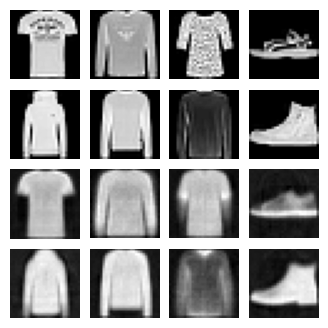

In [21]:
# Reconstruction
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Get 5 images
images = images[:8]
images = images.to(DEVICE)
images = images.view(images.size(0), -1)

with torch.no_grad():
    # Get Sample from the model
    images_hat, _, _ = model(images)
    images_hat = images_hat.view(images.size(0), 1, 28, 28)
    recon_images = torch.cat([images_hat.view(-1, 1, 28, 28)])
    comparison = torch.cat([images.view(-1, 1, 28, 28), recon_images])
    #save_image(comparison.cpu(),path, nrow=images.size(0))

# Show reconstruction
fig = plt.figure(figsize=(4, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, comparison):
    ax.imshow(im.cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')

# Save the figure
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['latent_dim']) + '_' + str(config['seed']) + '_reconstruction'
plt.savefig(f'../../results/figures/VAE/{name}.png')
plt.show() 

# Plot Latent


(60000, 16)
(60000,)


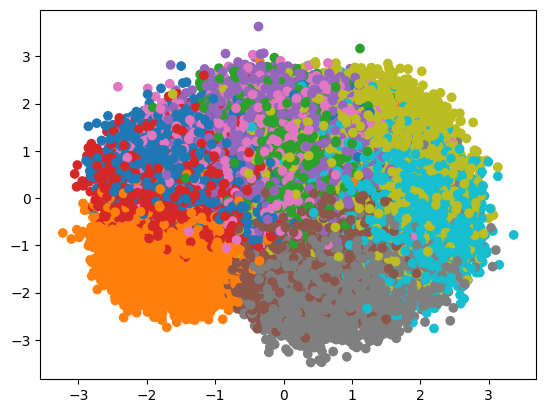

In [22]:
# Latent Space
latent_spaces = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in train_loader:
    images = images.to(DEVICE)
    images = images.view(images.size(0), -1)
    latent_space = model.get_latent_space(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(latent_space.shape)
print(all_labels.shape)

# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Save the plot
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['latent_dim']) + '_' + str(config['seed']) + '_PCA.png'
path = '../../results/figures/VAE/' + name

plot.figure.savefig(path)



